In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

##################
from tqdm import tqdm, trange
#from tqdm.notebook import tqdm googlecolab
import tensorflow as tf 

from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Bidirectional,GRU
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred - y_true)))
    
    
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, single_step=False):
  data = []
  labels = []
  
  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size
  
  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(dataset[indices])
    
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])
  
  return np.array(data), np.array(labels)

In [ ]:
df = pd.read_excel("/content/比特幣LSTM.xlsx", index_col="日期")
df

,開盤價,最高價,最低價,收盤價,交易量,市值
日期,,,,,,
2017-11-20,241742.87,250747.75,238957.76,246658.84,104901181393,4116172686710
2017-11-21,246812.25,250326.23,233052.08,242202.36,128661953099,4052700500486
2017-11-22,242403.13,248876.84,242288.33,247556.97,109034971601,4135038245415
2017-11-23,246922.00,247418.49,241187.22,241187.22,126730046041,4026030447207
2017-11-24,242244.82,250831.22,237957.91,247239.30,151773481111,4135372781119
...,...,...,...,...,...,...
2023-01-22,690917.84,699372.86,679085.47,689167.46,750624709601,13280094580403
2023-01-23,689187.88,700905.98,686935.17,695096.73,804379013651,13405780795161
2023-01-24,694951.13,700736.14,683031.76,685495.65,800284826506,13221500684810


In [ ]:
y = df["收盤價"]
x = df

In [ ]:
y

日期
2017-11-20    246658.84
2017-11-21    242202.36
2017-11-22    247556.97
2017-11-23    241187.22
2017-11-24    247239.30
                ...    
2023-01-22    689167.46
2023-01-23    695096.73
2023-01-24    685495.65
2023-01-25    699606.54
2023-01-26    696142.65
Name: 收盤價, Length: 1894, dtype: float64

In [ ]:
x

,開盤價,最高價,最低價,收盤價,交易量,市值
日期,,,,,,
2017-11-20,241742.87,250747.75,238957.76,246658.84,104901181393,4116172686710
2017-11-21,246812.25,250326.23,233052.08,242202.36,128661953099,4052700500486
2017-11-22,242403.13,248876.84,242288.33,247556.97,109034971601,4135038245415
2017-11-23,246922.00,247418.49,241187.22,241187.22,126730046041,4026030447207
2017-11-24,242244.82,250831.22,237957.91,247239.30,151773481111,4135372781119
...,...,...,...,...,...,...
2023-01-22,690917.84,699372.86,679085.47,689167.46,750624709601,13280094580403
2023-01-23,689187.88,700905.98,686935.17,695096.73,804379013651,13405780795161
2023-01-24,694951.13,700736.14,683031.76,685495.65,800284826506,13221500684810


In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
y=scaler.fit_transform(y.to_frame())
scaler1=MinMaxScaler(feature_range=(0,1))
x=scaler1.fit_transform(x)

In [ ]:
## 重要參數:

## 10
## 使用"前10天"的開盤價、最高價、最低價、收盤價、成交量，預測"隔1天"的收盤價。
## history_size 輸入長度(input_length) 本文選10 target_size 預測長度 本文選1
## code
## x,y=multivariate_data( x ,y , 0 ,None, 10 , 1 ,single_step=True)
## x,y=multivariate_data( x ,y , 0 ,None, 10 , 1 ,single_step=True)

## 1
## history_size 輸入長度 本文選10 target_size 預測長度 本文選1
## code
## x,y=multivariate_data( x ,y , 0 ,None, 10 , 1 ,single_step=True)

## 5
##（batch_size，time_steps，seq_len） : 1163組，5天(周一至周五)，"5個變數(五個column變數)"
## input_dim為變數數量，本文總共有5個變數(五個column變數)
## lstm00 = lstm_model0(10,5) 

## lstm_model(input_length = 10, input_dim = 5)
## input length為輸入的時間長度，本文選用10天；input_dim為變數數量，本文總共有5個變數

In [ ]:
x,y=multivariate_data( x ,y , 0 ,None, 10 , 1 ,single_step=True)
split =0.95
x_,y_  = x[0:int(split*len(x))] , y[0:int(split*len(x))]
x_test ,y_test   = x[int(split*len(x)):] , y[int(split*len(x)):]
split= 0.8
x_train,y_train  =x_[:int(split*len(x_))] , y_[:int(split*len(x_))]
x_vaild,y_vaild  =x_[int(split*len(x_)):] , y_[int(split*len(x_)):]

In [ ]:
trainindex= df.index[10:len(x_train)+10]
valindex = df.index[len(x_train)+10:len(x_train)+10+len(x_vaild)]

In [ ]:
print(x_train.shape,y_train.shape,x_vaild.shape,y_vaild.shape)

(1430, 10, 6) (1430, 1) (358, 10, 6) (358, 1)


In [ ]:
## 單層的LSTM
def lstm_model0(input_length, input_dim):

    d=0.3
    model0= Sequential()
    model0.add(LSTM(32,input_shape=(input_length, input_dim),return_sequences=False))
    model0.add(Dropout(d))
   
    model0.add(Dense(1,activation='linear'))#linear / softmax(多分類) / sigmoid(二分法)

    # optimizer = tf.keras.optimizers.Adam(lr=0.00005)
    model0.compile(loss='mse',optimizer='adam')#loss=mse/categorical_crossentropy
    return model0

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=300, monitor = 'val_loss')
    ]
filepath="lstm.best.hdf6"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min',save_best_only=True)

call_backlist = [ my_callbacks,checkpoint]
callbacks=call_backlist
lstm0 = lstm_model0(10,6)

In [ ]:
historylstm0 = lstm0.fit( x_train, y_train, batch_size=30,shuffle=False , epochs=1000,validation_data=(x_vaild,y_vaild),callbacks=call_backlist)
lstm0.summary()

Epoch 1/1000
37/48 [======================>.......] - ETA: 0s - loss: 0.0038
Epoch 1: val_loss improved from inf to 0.01319, saving model to lstm.best.hdf6


48/48 [==============================] - 6s 92ms/step - loss: 0.0119 - val_loss: 0.0132
Epoch 2/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0053
Epoch 2: val_loss improved from 0.01319 to 0.00178, saving model to lstm.best.hdf6


48/48 [==============================] - 5s 98ms/step - loss: 0.0075 - val_loss: 0.0018
Epoch 3/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0042
Epoch 3: val_loss did not improve from 0.00178
48/48 [==============================] - 0s 8ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 4/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0033    
Epoch 4: val_loss did not improve from 0.00178
48/48 [==============================] - 0s 7ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 5/1000
36/48 [=====================>........] - ETA: 0s - loss: 4.9254e-04
Epoch 5: val_loss did not improve from 0.00178
48/48 [==============================] - 0s 5ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 6/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0029    
Epoch 6: val_loss did not improve from 0.00178
48/48 [==============================] - 0s 5ms/step - loss: 0.0042 - val_loss: 0.0064
Epoch 7/1000
40/48 [========================>.....] - ET

48/48 [==============================] - 4s 78ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 9/1000
48/48 [==============================] - ETA: 0s - loss: 0.0030
Epoch 9: val_loss did not improve from 0.00134
48/48 [==============================] - 1s 11ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 10/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0025    
Epoch 10: val_loss improved from 0.00134 to 0.00127, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 93ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 11/1000
41/48 [========================>.....] - ETA: 0s - loss: 0.0013    
Epoch 11: val_loss improved from 0.00127 to 0.00126, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 88ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 12/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0019    
Epoch 12: val_loss did not improve from 0.00126
48/48 [==============================] - 1s 11ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 13/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0019    
Epoch 13: val_loss did not improve from 0.00126
48/48 [==============================] - 0s 8ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 14/1000
41/48 [========================>.....] - ETA: 0s - loss: 0.0013    
Epoch 14: val_loss improved from 0.00126 to 0.00125, saving model to lstm.best.hdf6


48/48 [==============================] - 5s 100ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 15/1000
41/48 [========================>.....] - ETA: 0s - loss: 0.0012    
Epoch 15: val_loss improved from 0.00125 to 0.00123, saving model to lstm.best.hdf6


48/48 [==============================] - 5s 115ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 16/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0018    
Epoch 16: val_loss did not improve from 0.00123
48/48 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 17/1000
48/48 [==============================] - ETA: 0s - loss: 0.0021    
Epoch 17: val_loss did not improve from 0.00123
48/48 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 18/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0014    
Epoch 18: val_loss improved from 0.00123 to 0.00122, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 95ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 19/1000
41/48 [========================>.....] - ETA: 0s - loss: 9.7696e-04
Epoch 19: val_loss did not improve from 0.00122
48/48 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 20/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0018    
Epoch 20: val_loss did not improve from 0.00122
48/48 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 21/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0021    
Epoch 21: val_loss did not improve from 0.00122
48/48 [==============================] - 0s 7ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 22/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0017    
Epoch 22: val_loss improved from 0.00122 to 0.00120, saving model to lstm.best.hdf6


48/48 [==============================] - 5s 115ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 23/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0016    
Epoch 23: val_loss did not improve from 0.00120
48/48 [==============================] - 0s 8ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 24/1000
37/48 [======================>.......] - ETA: 0s - loss: 2.6999e-04
Epoch 24: val_loss improved from 0.00120 to 0.00109, saving model to lstm.best.hdf6


48/48 [==============================] - 5s 103ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 25/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0017    
Epoch 25: val_loss did not improve from 0.00109
48/48 [==============================] - 0s 7ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 26/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 26: val_loss did not improve from 0.00109
48/48 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 27/1000
41/48 [========================>.....] - ETA: 0s - loss: 0.0020    
Epoch 27: val_loss did not improve from 0.00109
48/48 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0062
Epoch 28/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0021    
Epoch 28: val_loss did not improve from 0.00109
48/48 [==============================] - 0s 8ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 29/1000
44/48 [==========================

48/48 [==============================] - 4s 93ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 33/1000
38/48 [======================>.......] - ETA: 0s - loss: 2.9105e-04
Epoch 33: val_loss improved from 0.00107 to 0.00104, saving model to lstm.best.hdf6


48/48 [==============================] - 5s 99ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 34/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0017    
Epoch 34: val_loss did not improve from 0.00104
48/48 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 35/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0013    
Epoch 35: val_loss did not improve from 0.00104
48/48 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 36/1000
48/48 [==============================] - ETA: 0s - loss: 0.0017    
Epoch 36: val_loss did not improve from 0.00104
48/48 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 37/1000
41/48 [========================>.....] - ETA: 0s - loss: 8.9056e-04
Epoch 37: val_loss improved from 0.00104 to 0.00103, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 83ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 38/1000
42/48 [=========================>....] - ETA: 0s - loss: 8.1184e-04
Epoch 38: val_loss improved from 0.00103 to 0.00099, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 87ms/step - loss: 0.0014 - val_loss: 9.9285e-04
Epoch 39/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0015    
Epoch 39: val_loss did not improve from 0.00099
48/48 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 40/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0014    
Epoch 40: val_loss did not improve from 0.00099
48/48 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 41/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0015    
Epoch 41: val_loss did not improve from 0.00099
48/48 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 42/1000
38/48 [======================>.......] - ETA: 0s - loss: 3.3910e-04
Epoch 42: val_loss did not improve from 0.00099
48/48 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 43/1000
46/48 [===================

48/48 [==============================] - 5s 97ms/step - loss: 0.0017 - val_loss: 9.7292e-04
Epoch 50/1000
39/48 [=======================>......] - ETA: 0s - loss: 4.7194e-04
Epoch 50: val_loss did not improve from 0.00097
48/48 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 51/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0013    
Epoch 51: val_loss did not improve from 0.00097
48/48 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 52/1000
40/48 [========================>.....] - ETA: 0s - loss: 6.4408e-04
Epoch 52: val_loss did not improve from 0.00097
48/48 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 53/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0013    
Epoch 53: val_loss did not improve from 0.00097
48/48 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 9.9610e-04
Epoch 54/1000
47/48 [===============

48/48 [==============================] - 4s 82ms/step - loss: 0.0016 - val_loss: 9.6053e-04
Epoch 55/1000
39/48 [=======================>......] - ETA: 0s - loss: 4.2244e-04
Epoch 55: val_loss did not improve from 0.00096
48/48 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 56/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0014    
Epoch 56: val_loss did not improve from 0.00096
48/48 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 9.6075e-04
Epoch 57/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0012    
Epoch 57: val_loss did not improve from 0.00096
48/48 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 9.7260e-04
Epoch 58/1000
40/48 [========================>.....] - ETA: 0s - loss: 6.2661e-04
Epoch 58: val_loss did not improve from 0.00096
48/48 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 9.8579e-04
Epoch 59/1000
46/48 [=======

48/48 [==============================] - 5s 101ms/step - loss: 0.0017 - val_loss: 9.2024e-04
Epoch 66/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 66: val_loss did not improve from 0.00092
48/48 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 9.3425e-04
Epoch 67/1000
48/48 [==============================] - ETA: 0s - loss: 0.0015    
Epoch 67: val_loss did not improve from 0.00092
48/48 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 68/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0014    
Epoch 68: val_loss did not improve from 0.00092
48/48 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 9.4768e-04
Epoch 69/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0013    
Epoch 69: val_loss did not improve from 0.00092
48/48 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 70/1000
42/48 [==========

48/48 [==============================] - 4s 82ms/step - loss: 0.0018 - val_loss: 9.0529e-04
Epoch 71/1000
39/48 [=======================>......] - ETA: 0s - loss: 4.6069e-04
Epoch 71: val_loss did not improve from 0.00091
48/48 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 9.3866e-04
Epoch 72/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0013    
Epoch 72: val_loss did not improve from 0.00091
48/48 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 73/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0014    
Epoch 73: val_loss did not improve from 0.00091
48/48 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 74/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0010    
Epoch 74: val_loss did not improve from 0.00091
48/48 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 9.4049e-04
Epoch 75/1000
44/48 [===========

48/48 [==============================] - 5s 99ms/step - loss: 0.0014 - val_loss: 8.8116e-04
Epoch 85/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0013    
Epoch 85: val_loss did not improve from 0.00088
48/48 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 86/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0014    
Epoch 86: val_loss did not improve from 0.00088
48/48 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 87/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 87: val_loss did not improve from 0.00088
48/48 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 88/1000
40/48 [========================>.....] - ETA: 0s - loss: 6.8019e-04
Epoch 88: val_loss did not improve from 0.00088
48/48 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 8.8463e-04
Epoch 89/1000
43/48 [===============

48/48 [==============================] - 4s 82ms/step - loss: 0.0015 - val_loss: 8.7216e-04
Epoch 100/1000
48/48 [==============================] - ETA: 0s - loss: 0.0016    
Epoch 100: val_loss improved from 0.00087 to 0.00087, saving model to lstm.best.hdf6


48/48 [==============================] - 5s 104ms/step - loss: 0.0016 - val_loss: 8.7021e-04
Epoch 101/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0013    
Epoch 101: val_loss did not improve from 0.00087
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 102/1000
39/48 [=======================>......] - ETA: 0s - loss: 4.6520e-04
Epoch 102: val_loss did not improve from 0.00087
48/48 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 103/1000
39/48 [=======================>......] - ETA: 0s - loss: 4.5997e-04
Epoch 103: val_loss did not improve from 0.00087
48/48 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 104/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 104: val_loss did not improve from 0.00087
48/48 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 105/1000
38/48 [=========

48/48 [==============================] - 4s 80ms/step - loss: 0.0015 - val_loss: 8.6983e-04
Epoch 111/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0013    
Epoch 111: val_loss did not improve from 0.00087
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 112/1000
38/48 [======================>.......] - ETA: 0s - loss: 4.2337e-04
Epoch 112: val_loss improved from 0.00087 to 0.00086, saving model to lstm.best.hdf6


48/48 [==============================] - 5s 106ms/step - loss: 0.0014 - val_loss: 8.5740e-04
Epoch 113/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 113: val_loss did not improve from 0.00086
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 114/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0016    
Epoch 114: val_loss did not improve from 0.00086
48/48 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 9.2195e-04
Epoch 115/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0011    
Epoch 115: val_loss did not improve from 0.00086
48/48 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 116/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0011    
Epoch 116: val_loss did not improve from 0.00086
48/48 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 117/1000
41/48 [=====

48/48 [==============================] - 4s 80ms/step - loss: 0.0014 - val_loss: 8.3744e-04
Epoch 125/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0010    
Epoch 125: val_loss did not improve from 0.00084
48/48 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 126/1000
44/48 [==========================>...] - ETA: 0s - loss: 9.8226e-04
Epoch 126: val_loss did not improve from 0.00084
48/48 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 127/1000
48/48 [==============================] - ETA: 0s - loss: 0.0016    
Epoch 127: val_loss did not improve from 0.00084
48/48 [==============================] - 0s 9ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 128/1000
48/48 [==============================] - ETA: 0s - loss: 0.0015    
Epoch 128: val_loss improved from 0.00084 to 0.00083, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 88ms/step - loss: 0.0015 - val_loss: 8.2891e-04
Epoch 129/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0013    
Epoch 129: val_loss did not improve from 0.00083
48/48 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 130/1000
39/48 [=======================>......] - ETA: 0s - loss: 5.1995e-04
Epoch 130: val_loss did not improve from 0.00083
48/48 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 9.0103e-04
Epoch 131/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0013    
Epoch 131: val_loss did not improve from 0.00083
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 8.6811e-04
Epoch 132/1000
41/48 [========================>.....] - ETA: 0s - loss: 8.4991e-04
Epoch 132: val_loss did not improve from 0.00083
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 133/1000
42/48 [==

48/48 [==============================] - 5s 109ms/step - loss: 0.0014 - val_loss: 8.2617e-04
Epoch 145/1000
38/48 [======================>.......] - ETA: 0s - loss: 4.4476e-04
Epoch 145: val_loss did not improve from 0.00083
48/48 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 146/1000
39/48 [=======================>......] - ETA: 0s - loss: 5.6075e-04
Epoch 146: val_loss did not improve from 0.00083
48/48 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 9.2518e-04
Epoch 147/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0011    
Epoch 147: val_loss did not improve from 0.00083
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 148/1000
39/48 [=======================>......] - ETA: 0s - loss: 5.3595e-04
Epoch 148: val_loss did not improve from 0.00083
48/48 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 9.1865e-04
Epoch 149/1000
44/48 [=

48/48 [==============================] - 4s 86ms/step - loss: 0.0014 - val_loss: 8.1682e-04
Epoch 176/1000
40/48 [========================>.....] - ETA: 0s - loss: 6.6821e-04
Epoch 176: val_loss did not improve from 0.00082
48/48 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 177/1000
43/48 [=========================>....] - ETA: 0s - loss: 9.3904e-04
Epoch 177: val_loss did not improve from 0.00082
48/48 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 9.7401e-04
Epoch 178/1000
48/48 [==============================] - ETA: 0s - loss: 0.0014    
Epoch 178: val_loss did not improve from 0.00082
48/48 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 179/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 179: val_loss did not improve from 0.00082
48/48 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 9.2018e-04
Epoch 180/1000
37/48 [==

48/48 [==============================] - 4s 94ms/step - loss: 0.0014 - val_loss: 8.0956e-04
Epoch 181/1000
37/48 [======================>.......] - ETA: 0s - loss: 3.7064e-04
Epoch 181: val_loss did not improve from 0.00081
48/48 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 182/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0012    
Epoch 182: val_loss did not improve from 0.00081
48/48 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 183/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0012    
Epoch 183: val_loss did not improve from 0.00081
48/48 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 184/1000
41/48 [========================>.....] - ETA: 0s - loss: 9.6521e-04
Epoch 184: val_loss did not improve from 0.00081
48/48 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 185/1000
40/48 [==========

48/48 [==============================] - 4s 81ms/step - loss: 0.0012 - val_loss: 8.0572e-04
Epoch 209/1000
44/48 [==========================>...] - ETA: 0s - loss: 9.4387e-04
Epoch 209: val_loss improved from 0.00081 to 0.00080, saving model to lstm.best.hdf6


48/48 [==============================] - 5s 103ms/step - loss: 0.0014 - val_loss: 8.0368e-04
Epoch 210/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0013    
Epoch 210: val_loss did not improve from 0.00080
48/48 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 211/1000
40/48 [========================>.....] - ETA: 0s - loss: 6.4520e-04
Epoch 211: val_loss did not improve from 0.00080
48/48 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 8.4226e-04
Epoch 212/1000
37/48 [======================>.......] - ETA: 0s - loss: 4.0480e-04
Epoch 212: val_loss did not improve from 0.00080
48/48 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 8.0875e-04
Epoch 213/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0012    
Epoch 213: val_loss did not improve from 0.00080
48/48 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 8.0553e-04
Epoch 214/1000
46/4

48/48 [==============================] - 4s 80ms/step - loss: 0.0014 - val_loss: 8.0200e-04
Epoch 224/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0013    
Epoch 224: val_loss did not improve from 0.00080
48/48 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 225/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0013    
Epoch 225: val_loss improved from 0.00080 to 0.00080, saving model to lstm.best.hdf6


48/48 [==============================] - 5s 105ms/step - loss: 0.0014 - val_loss: 8.0191e-04
Epoch 226/1000
48/48 [==============================] - ETA: 0s - loss: 0.0014    
Epoch 226: val_loss did not improve from 0.00080
48/48 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 8.1935e-04
Epoch 227/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0011    
Epoch 227: val_loss did not improve from 0.00080
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 228/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 228: val_loss did not improve from 0.00080
48/48 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 8.5975e-04
Epoch 229/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0011    
Epoch 229: val_loss did not improve from 0.00080
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 230/1000
43/48 [=

48/48 [==============================] - 4s 91ms/step - loss: 0.0013 - val_loss: 7.9776e-04
Epoch 249/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0012    
Epoch 249: val_loss did not improve from 0.00080
48/48 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 250/1000
48/48 [==============================] - ETA: 0s - loss: 0.0015    
Epoch 250: val_loss did not improve from 0.00080
48/48 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 8.0967e-04
Epoch 251/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0014    
Epoch 251: val_loss did not improve from 0.00080
48/48 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 9.6652e-04
Epoch 252/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0010    
Epoch 252: val_loss did not improve from 0.00080
48/48 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 8.0239e-04
Epoch 253/1000
45/48

48/48 [==============================] - 5s 98ms/step - loss: 0.0014 - val_loss: 7.9356e-04
Epoch 257/1000
41/48 [========================>.....] - ETA: 0s - loss: 7.5696e-04
Epoch 257: val_loss did not improve from 0.00079
48/48 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 9.9680e-04
Epoch 258/1000
36/48 [=====================>........] - ETA: 0s - loss: 3.8000e-04
Epoch 258: val_loss did not improve from 0.00079
48/48 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 8.0609e-04
Epoch 259/1000
41/48 [========================>.....] - ETA: 0s - loss: 8.8094e-04
Epoch 259: val_loss did not improve from 0.00079
48/48 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 260/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0011    
Epoch 260: val_loss did not improve from 0.00079
48/48 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 8.9466e-04
Epoch 261/1000
47/48

48/48 [==============================] - 4s 89ms/step - loss: 0.0014 - val_loss: 7.8865e-04
Epoch 262/1000
41/48 [========================>.....] - ETA: 0s - loss: 7.8110e-04
Epoch 262: val_loss did not improve from 0.00079
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 263/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 263: val_loss did not improve from 0.00079
48/48 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 264/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0013    
Epoch 264: val_loss did not improve from 0.00079
48/48 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 265/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0013    
Epoch 265: val_loss did not improve from 0.00079
48/48 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 266/1000
46/48 [==========

48/48 [==============================] - 4s 92ms/step - loss: 0.0011 - val_loss: 7.7557e-04
Epoch 304/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0012    
Epoch 304: val_loss did not improve from 0.00078
48/48 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 305/1000
37/48 [======================>.......] - ETA: 0s - loss: 4.1905e-04
Epoch 305: val_loss did not improve from 0.00078
48/48 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 8.6760e-04
Epoch 306/1000
40/48 [========================>.....] - ETA: 0s - loss: 6.2122e-04
Epoch 306: val_loss did not improve from 0.00078
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 8.1927e-04
Epoch 307/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 307: val_loss did not improve from 0.00078
48/48 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 308/1000
47/48 [==

48/48 [==============================] - 4s 78ms/step - loss: 0.0013 - val_loss: 7.7499e-04
Epoch 437/1000
40/48 [========================>.....] - ETA: 0s - loss: 8.4069e-04
Epoch 437: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 438/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0013    
Epoch 438: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 439/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0011    
Epoch 439: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 8.1281e-04
Epoch 440/1000
44/48 [==========================>...] - ETA: 0s - loss: 9.6726e-04
Epoch 440: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 8.2613e-04
Epoch 441/1000
48/48 [==

48/48 [==============================] - 5s 100ms/step - loss: 0.0013 - val_loss: 7.7456e-04
Epoch 450/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 450: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 9.1289e-04
Epoch 451/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 451: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 7.8555e-04
Epoch 452/1000
43/48 [=========================>....] - ETA: 0s - loss: 9.7019e-04
Epoch 452: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 9.0314e-04
Epoch 453/1000
41/48 [========================>.....] - ETA: 0s - loss: 9.7013e-04
Epoch 453: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 454/1000
39/4

48/48 [==============================] - 4s 93ms/step - loss: 0.0014 - val_loss: 7.7287e-04
Epoch 491/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0011    
Epoch 491: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 8.2468e-04
Epoch 492/1000
39/48 [=======================>......] - ETA: 0s - loss: 5.2815e-04
Epoch 492: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 8.1821e-04
Epoch 493/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0011    
Epoch 493: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 7.7608e-04
Epoch 494/1000
41/48 [========================>.....] - ETA: 0s - loss: 9.7193e-04
Epoch 494: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 8.9880e-04
Epoch 495/1000
4

48/48 [==============================] - 4s 92ms/step - loss: 0.0013 - val_loss: 7.6775e-04
Epoch 626/1000
41/48 [========================>.....] - ETA: 0s - loss: 8.8054e-04
Epoch 626: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 627/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0012    
Epoch 627: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 7.9530e-04
Epoch 628/1000
43/48 [=========================>....] - ETA: 0s - loss: 9.3145e-04
Epoch 628: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 8.5976e-04
Epoch 629/1000
39/48 [=======================>......] - ETA: 0s - loss: 5.2796e-04
Epoch 629: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 8.3273e-04
Epoch 630/1000
44/48

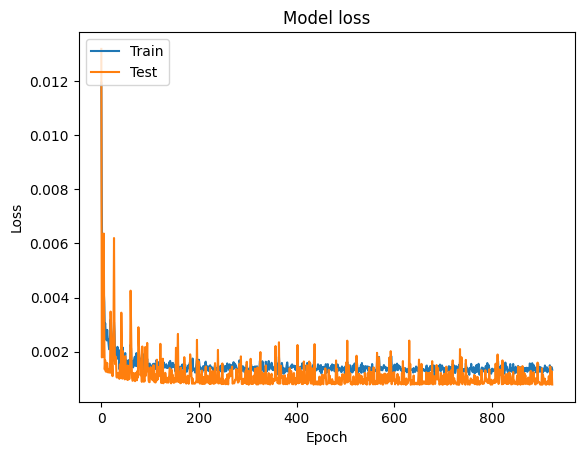

In [ ]:
plt.plot(historylstm0.history['loss'])
plt.plot(historylstm0.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

12/12 [==============================] - 0s 2ms/step


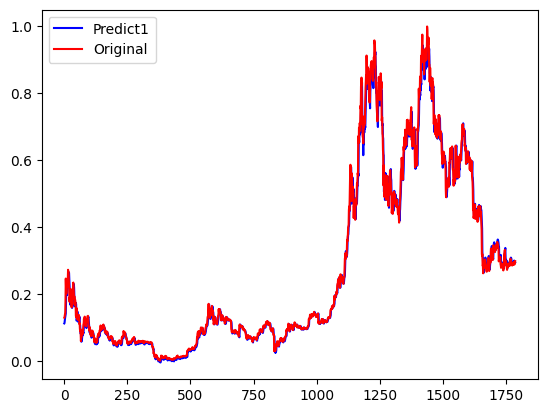

In [ ]:
lstm0train  = lstm0.predict(x_train)
lstm0val = lstm0.predict(x_vaild)
lstm0pre = lstm0.predict(x_test)
pre = lstm0.predict(x_train)
pre1=lstm0.predict(x_vaild)
fc=np.concatenate((pre,pre1))
yreal=np.concatenate((y_train,y_vaild))
plt.figure(facecolor='white')
pd.Series(fc.reshape(-1)).plot(color='blue', label='Predict1')
pd.Series(yreal.reshape(-1)).plot(color='red', label='Original')
plt.legend()
plt.show()

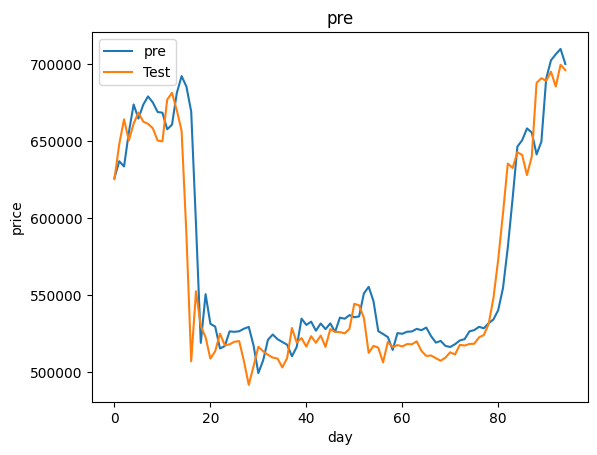

26465.857395249797

In [ ]:
lstm0pre= scaler.inverse_transform(lstm0pre)#將資料轉換回來
y_test = scaler.inverse_transform(y_test.reshape(-1,1))
plt.figure()
plt.plot(lstm0pre)
plt.plot(y_test)
plt.title('pre')
plt.ylabel('price')
plt.xlabel('day')
plt.legend(['pre', 'Test'], loc='upper left')
plt.show()
root_mean_squared_error(lstm0pre,y_test)

In [ ]:
## 兩層 LSTM
def lstm_model1(input_length, input_dim):

    d=0.3
    model1= Sequential()
    model1.add(LSTM(64,input_shape=(input_length, input_dim),return_sequences=True))
    model1.add(Dropout(d))

    model1.add(LSTM(32,input_shape=(input_length, input_dim),return_sequences=False))
    model1.add(Dropout(d))
    
    model1.add(Dense(1,activation='linear'))#linear / softmax(多分類) / sigmoid(二分法)

    # optimizer = tf.keras.optimizers.Adam(lr=0.00005)
    model1.compile(loss='mse',optimizer='adam')#loss=mse/categorical_crossentropy
    return model1 

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=300, monitor = 'val_loss')
    ]
filepath="lstm.best.hdf6"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min',save_best_only=True)

call_backlist = [ my_callbacks,checkpoint]
callbacks=call_backlist
lstm1 = lstm_model1(10,6)
historylstm1 = lstm1.fit( x_train, y_train, batch_size=30,shuffle=False , epochs=1000,validation_data=(x_vaild,y_vaild),callbacks=call_backlist)
lstm1.summary()

Epoch 1/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0084
Epoch 1: val_loss improved from inf to 0.00336, saving model to lstm.best.hdf6


48/48 [==============================] - 13s 192ms/step - loss: 0.0095 - val_loss: 0.0034
Epoch 2/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0088
Epoch 2: val_loss did not improve from 0.00336
48/48 [==============================] - 1s 12ms/step - loss: 0.0107 - val_loss: 0.0110
Epoch 3/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0057
Epoch 3: val_loss did not improve from 0.00336
48/48 [==============================] - 1s 12ms/step - loss: 0.0098 - val_loss: 0.0145
Epoch 4/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0063
Epoch 4: val_loss did not improve from 0.00336
48/48 [==============================] - 1s 12ms/step - loss: 0.0071 - val_loss: 0.0099
Epoch 5/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0035
Epoch 5: val_loss improved from 0.00336 to 0.00305, saving model to lstm.best.hdf6


48/48 [==============================] - 8s 180ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 6/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0026    
Epoch 6: val_loss improved from 0.00305 to 0.00196, saving model to lstm.best.hdf6


48/48 [==============================] - 8s 180ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 7/1000
48/48 [==============================] - ETA: 0s - loss: 0.0035
Epoch 7: val_loss did not improve from 0.00196
48/48 [==============================] - 1s 12ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 8/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0035
Epoch 8: val_loss did not improve from 0.00196
48/48 [==============================] - 1s 12ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 9/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0035
Epoch 9: val_loss did not improve from 0.00196
48/48 [==============================] - 1s 13ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 10/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0037
Epoch 10: val_loss did not improve from 0.00196
48/48 [==============================] - 1s 12ms/step - loss: 0.0046 - val_loss: 0.0060
Epoch 11/1000
47/48 [============================>.] - ETA: 0

48/48 [==============================] - 8s 167ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 16/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0021    
Epoch 16: val_loss did not improve from 0.00159
48/48 [==============================] - 1s 11ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 17/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0042
Epoch 17: val_loss did not improve from 0.00159
48/48 [==============================] - 1s 12ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 18/1000
48/48 [==============================] - ETA: 0s - loss: 0.0064
Epoch 18: val_loss did not improve from 0.00159
48/48 [==============================] - 1s 12ms/step - loss: 0.0064 - val_loss: 0.0110
Epoch 19/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0027
Epoch 19: val_loss did not improve from 0.00159
48/48 [==============================] - 1s 13ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 20/1000
47/48 [============================>.

48/48 [==============================] - 10s 209ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 29/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0018    
Epoch 29: val_loss improved from 0.00133 to 0.00128, saving model to lstm.best.hdf6


48/48 [==============================] - 8s 171ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 30/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0019    
Epoch 30: val_loss did not improve from 0.00128
48/48 [==============================] - 1s 12ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 31/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0026
Epoch 31: val_loss did not improve from 0.00128
48/48 [==============================] - 1s 11ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 32/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0023    
Epoch 32: val_loss did not improve from 0.00128
48/48 [==============================] - 1s 12ms/step - loss: 0.0036 - val_loss: 0.0049
Epoch 33/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0020
Epoch 33: val_loss did not improve from 0.00128
48/48 [==============================] - 1s 13ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 34/1000
46/48 [==========================

48/48 [==============================] - 9s 186ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 42/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0021
Epoch 42: val_loss did not improve from 0.00123
48/48 [==============================] - 1s 12ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 43/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0021
Epoch 43: val_loss did not improve from 0.00123
48/48 [==============================] - 1s 12ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 44/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0018    
Epoch 44: val_loss did not improve from 0.00123
48/48 [==============================] - 1s 12ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 45/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0019    
Epoch 45: val_loss did not improve from 0.00123
48/48 [==============================] - 1s 13ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 46/1000
47/48 [==========================

48/48 [==============================] - 8s 174ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 53/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0012    
Epoch 53: val_loss improved from 0.00121 to 0.00113, saving model to lstm.best.hdf6


48/48 [==============================] - 8s 171ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 54/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0020
Epoch 54: val_loss did not improve from 0.00113
48/48 [==============================] - 1s 12ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 55/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0016    
Epoch 55: val_loss did not improve from 0.00113
48/48 [==============================] - 1s 12ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 56/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 56: val_loss did not improve from 0.00113
48/48 [==============================] - 1s 12ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 57/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 57: val_loss did not improve from 0.00113
48/48 [==============================] - 1s 11ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 58/1000
47/48 [============================>.

48/48 [==============================] - 9s 192ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 73/1000
48/48 [==============================] - ETA: 0s - loss: 0.0018
Epoch 73: val_loss did not improve from 0.00107
48/48 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 74/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0015    
Epoch 74: val_loss did not improve from 0.00107
48/48 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 75/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0014    
Epoch 75: val_loss improved from 0.00107 to 0.00104, saving model to lstm.best.hdf6


48/48 [==============================] - 8s 163ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 76/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0015    
Epoch 76: val_loss did not improve from 0.00104
48/48 [==============================] - 1s 15ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 77/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0014    
Epoch 77: val_loss did not improve from 0.00104
48/48 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 78/1000
48/48 [==============================] - ETA: 0s - loss: 0.0019
Epoch 78: val_loss did not improve from 0.00104
48/48 [==============================] - 1s 12ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 79/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0018
Epoch 79: val_loss did not improve from 0.00104
48/48 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 80/1000
45/48 [==========================

48/48 [==============================] - 8s 161ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 100/1000
48/48 [==============================] - ETA: 0s - loss: 0.0018
Epoch 100: val_loss did not improve from 0.00101
48/48 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 101/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 101: val_loss did not improve from 0.00101
48/48 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 102/1000
48/48 [==============================] - ETA: 0s - loss: 0.0023
Epoch 102: val_loss did not improve from 0.00101
48/48 [==============================] - 1s 16ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 103/1000
48/48 [==============================] - ETA: 0s - loss: 0.0020
Epoch 103: val_loss did not improve from 0.00101
48/48 [==============================] - 1s 16ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 104/1000
47/48 [=========================

48/48 [==============================] - 8s 168ms/step - loss: 0.0017 - val_loss: 9.9793e-04
Epoch 116/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0012    
Epoch 116: val_loss did not improve from 0.00100
48/48 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 117/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0015    
Epoch 117: val_loss did not improve from 0.00100
48/48 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 118/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0014    
Epoch 118: val_loss did not improve from 0.00100
48/48 [==============================] - 1s 12ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 119/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0014    
Epoch 119: val_loss did not improve from 0.00100
48/48 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 120/1000
47/48 [=====

48/48 [==============================] - 9s 198ms/step - loss: 0.0017 - val_loss: 9.6122e-04
Epoch 127/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0014    
Epoch 127: val_loss did not improve from 0.00096
48/48 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 128/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0018
Epoch 128: val_loss did not improve from 0.00096
48/48 [==============================] - 1s 12ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 129/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0017
Epoch 129: val_loss did not improve from 0.00096
48/48 [==============================] - 1s 13ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 130/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0016
Epoch 130: val_loss did not improve from 0.00096
48/48 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 131/1000
44/48 [=================

48/48 [==============================] - 8s 160ms/step - loss: 0.0017 - val_loss: 9.4408e-04
Epoch 140/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 140: val_loss did not improve from 0.00094
48/48 [==============================] - 1s 14ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 141/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 141: val_loss improved from 0.00094 to 0.00092, saving model to lstm.best.hdf6


48/48 [==============================] - 8s 171ms/step - loss: 0.0017 - val_loss: 9.2246e-04
Epoch 142/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0014
Epoch 142: val_loss did not improve from 0.00092
48/48 [==============================] - 1s 13ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 143/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0016
Epoch 143: val_loss did not improve from 0.00092
48/48 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 144/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0013    
Epoch 144: val_loss did not improve from 0.00092
48/48 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 9.3753e-04
Epoch 145/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0016    
Epoch 145: val_loss did not improve from 0.00092
48/48 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 146/1000
48/48 [=========

48/48 [==============================] - 9s 198ms/step - loss: 0.0016 - val_loss: 9.1441e-04
Epoch 173/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0014
Epoch 173: val_loss improved from 0.00091 to 0.00086, saving model to lstm.best.hdf6


48/48 [==============================] - 8s 166ms/step - loss: 0.0016 - val_loss: 8.5533e-04
Epoch 174/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0014    
Epoch 174: val_loss did not improve from 0.00086
48/48 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 175/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 175: val_loss did not improve from 0.00086
48/48 [==============================] - 1s 12ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 176/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0019
Epoch 176: val_loss did not improve from 0.00086
48/48 [==============================] - 1s 12ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 177/1000
48/48 [==============================] - ETA: 0s - loss: 0.0023
Epoch 177: val_loss did not improve from 0.00086
48/48 [==============================] - 1s 12ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 178/1000
47/48 [=================

48/48 [==============================] - 7s 159ms/step - loss: 0.0016 - val_loss: 8.4044e-04
Epoch 222/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 222: val_loss did not improve from 0.00084
48/48 [==============================] - 1s 12ms/step - loss: 0.0015 - val_loss: 8.4277e-04
Epoch 223/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0014    
Epoch 223: val_loss did not improve from 0.00084
48/48 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 8.8003e-04
Epoch 224/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 224: val_loss did not improve from 0.00084
48/48 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 225/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0014    
Epoch 225: val_loss did not improve from 0.00084
48/48 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 9.3905e-04
Epoch 226/1000
47/48 [=

48/48 [==============================] - 7s 156ms/step - loss: 0.0014 - val_loss: 8.3001e-04
Epoch 272/1000
48/48 [==============================] - ETA: 0s - loss: 0.0015
Epoch 272: val_loss did not improve from 0.00083
48/48 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 8.8614e-04
Epoch 273/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 273: val_loss did not improve from 0.00083
48/48 [==============================] - 1s 15ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 274/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0013
Epoch 274: val_loss did not improve from 0.00083
48/48 [==============================] - 1s 17ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 275/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0013    
Epoch 275: val_loss did not improve from 0.00083
48/48 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 276/1000
44/48 [=============

48/48 [==============================] - 7s 156ms/step - loss: 0.0016 - val_loss: 8.1334e-04
Epoch 281/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0016
Epoch 281: val_loss did not improve from 0.00081
48/48 [==============================] - 1s 16ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 282/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0018
Epoch 282: val_loss did not improve from 0.00081
48/48 [==============================] - 1s 16ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 283/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 283: val_loss did not improve from 0.00081
48/48 [==============================] - 1s 12ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 284/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 284: val_loss did not improve from 0.00081
48/48 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 8.5679e-04
Epoch 285/1000
45/48 [=================

48/48 [==============================] - 10s 216ms/step - loss: 0.0015 - val_loss: 8.0743e-04
Epoch 308/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 308: val_loss did not improve from 0.00081
48/48 [==============================] - 1s 13ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 309/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 309: val_loss did not improve from 0.00081
48/48 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 310/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 310: val_loss did not improve from 0.00081
48/48 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 311/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 311: val_loss did not improve from 0.00081
48/48 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 312/1000
48/48 [================

48/48 [==============================] - 7s 156ms/step - loss: 0.0015 - val_loss: 8.0495e-04
Epoch 347/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0014
Epoch 347: val_loss did not improve from 0.00080
48/48 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 348/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0015    
Epoch 348: val_loss did not improve from 0.00080
48/48 [==============================] - 1s 13ms/step - loss: 0.0016 - val_loss: 9.4392e-04
Epoch 349/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0012    
Epoch 349: val_loss did not improve from 0.00080
48/48 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 8.5249e-04
Epoch 350/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0012
Epoch 350: val_loss did not improve from 0.00080
48/48 [==============================] - 1s 14ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 351/1000
46/48 [=====

48/48 [==============================] - 8s 166ms/step - loss: 0.0014 - val_loss: 8.0249e-04
Epoch 439/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0013    
Epoch 439: val_loss did not improve from 0.00080
48/48 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 440/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 440: val_loss did not improve from 0.00080
48/48 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 9.7944e-04
Epoch 441/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0015    
Epoch 441: val_loss did not improve from 0.00080
48/48 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 442/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0014    
Epoch 442: val_loss did not improve from 0.00080
48/48 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 443/1000
47/48 [=====

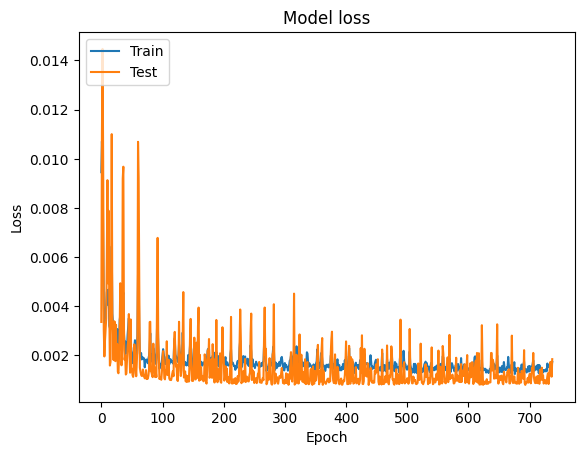

In [ ]:
plt.plot(historylstm1.history['loss'])
plt.plot(historylstm1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

12/12 [==============================] - 0s 4ms/step


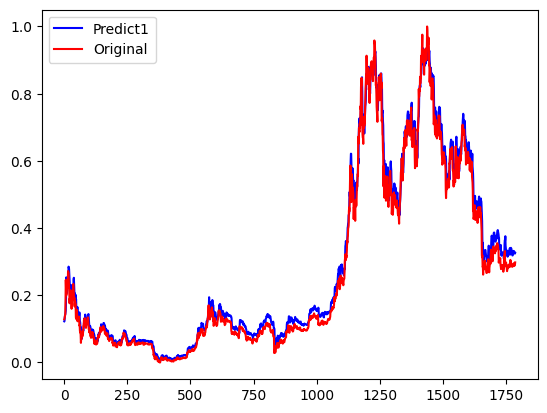

In [ ]:
lstm1train  = lstm1.predict(x_train)
lstm1val = lstm1.predict(x_vaild)
lstm1pre = lstm1.predict(x_test)
pre = lstm1.predict(x_train)
pre1=lstm1.predict(x_vaild)
fc=np.concatenate((pre,pre1))
yreal=np.concatenate((y_train,y_vaild))
plt.figure(facecolor='white')
pd.Series(fc.reshape(-1)).plot(color='blue', label='Predict1')
pd.Series(yreal.reshape(-1)).plot(color='red', label='Original')
plt.legend()
plt.show()

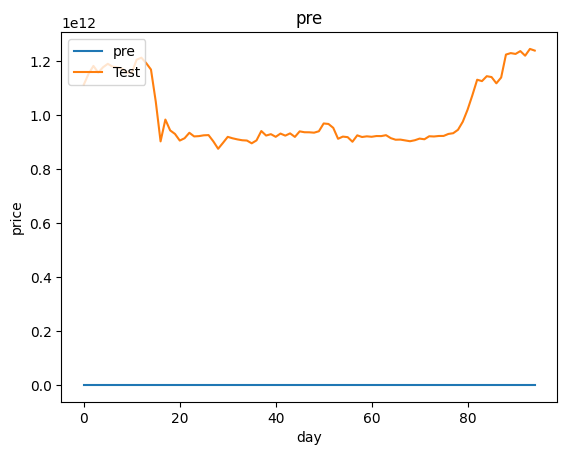

1009468158248.8854

In [ ]:
lstm1pre= scaler.inverse_transform(lstm1pre)#將資料轉換回來
y_test = scaler.inverse_transform(y_test.reshape(-1,1))
plt.figure()
plt.plot(lstm1pre)
plt.plot(y_test)
plt.title('pre')
plt.ylabel('price')
plt.xlabel('day')
plt.legend(['pre', 'Test'], loc='upper left')
plt.show()
root_mean_squared_error(lstm1pre,y_test)

In [ ]:
df = df.drop(["市值"], axis=1)

In [ ]:
df

,開盤價,最高價,最低價,收盤價,交易量
日期,,,,,
2017-11-20,241742.87,250747.75,238957.76,246658.84,104901181393
2017-11-21,246812.25,250326.23,233052.08,242202.36,128661953099
2017-11-22,242403.13,248876.84,242288.33,247556.97,109034971601
2017-11-23,246922.00,247418.49,241187.22,241187.22,126730046041
2017-11-24,242244.82,250831.22,237957.91,247239.30,151773481111
...,...,...,...,...,...
2023-01-22,690917.84,699372.86,679085.47,689167.46,750624709601
2023-01-23,689187.88,700905.98,686935.17,695096.73,804379013651
2023-01-24,694951.13,700736.14,683031.76,685495.65,800284826506


In [ ]:
y = df["收盤價"]
x = df

In [ ]:
y

日期
2017-11-20    246658.84
2017-11-21    242202.36
2017-11-22    247556.97
2017-11-23    241187.22
2017-11-24    247239.30
                ...    
2023-01-22    689167.46
2023-01-23    695096.73
2023-01-24    685495.65
2023-01-25    699606.54
2023-01-26    696142.65
Name: 收盤價, Length: 1894, dtype: float64

In [ ]:
x

,開盤價,最高價,最低價,收盤價,交易量
日期,,,,,
2017-11-20,241742.87,250747.75,238957.76,246658.84,104901181393
2017-11-21,246812.25,250326.23,233052.08,242202.36,128661953099
2017-11-22,242403.13,248876.84,242288.33,247556.97,109034971601
2017-11-23,246922.00,247418.49,241187.22,241187.22,126730046041
2017-11-24,242244.82,250831.22,237957.91,247239.30,151773481111
...,...,...,...,...,...
2023-01-22,690917.84,699372.86,679085.47,689167.46,750624709601
2023-01-23,689187.88,700905.98,686935.17,695096.73,804379013651
2023-01-24,694951.13,700736.14,683031.76,685495.65,800284826506


In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
y=scaler.fit_transform(y.to_frame())
scaler1=MinMaxScaler(feature_range=(0,1))
x=scaler1.fit_transform(x)

In [ ]:
x,y=multivariate_data( x ,y , 0 ,None, 10 , 1 ,single_step=True)
split =0.95
x_,y_  = x[0:int(split*len(x))] , y[0:int(split*len(x))]
x_test ,y_test   = x[int(split*len(x)):] , y[int(split*len(x)):]
split= 0.8
x_train,y_train  =x_[:int(split*len(x_))] , y_[:int(split*len(x_))]
x_vaild,y_vaild  =x_[int(split*len(x_)):] , y_[int(split*len(x_)):]

In [ ]:
trainindex= df.index[10:len(x_train)+10]
valindex = df.index[len(x_train)+10:len(x_train)+10+len(x_vaild)]

In [ ]:
print(x_train.shape,y_train.shape,x_vaild.shape,y_vaild.shape)

(1430, 10, 5) (1430, 1) (358, 10, 5) (358, 1)


In [ ]:
## 單層的LSTM
def lstm_model3(input_length, input_dim):

    d=0.3
    model3= Sequential()
    model3.add(LSTM(32,input_shape=(input_length, input_dim),return_sequences=False))
    model3.add(Dropout(d))
   
    model3.add(Dense(1,activation='linear'))#linear / softmax(多分類) / sigmoid(二分法)

    # optimizer = tf.keras.optimizers.Adam(lr=0.00005)
    model3.compile(loss='mse',optimizer='adam')#loss=mse/categorical_crossentropy
    return model3

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=300, monitor = 'val_loss')
    ]
filepath="lstm.best.hdf6"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min',save_best_only=True)

call_backlist = [ my_callbacks,checkpoint]
callbacks=call_backlist
lstm3 = lstm_model3(10,5)

In [ ]:
historylstm3 = lstm3.fit( x_train, y_train, batch_size=30,shuffle=False , epochs=1000,validation_data=(x_vaild,y_vaild),callbacks=call_backlist)
lstm3.summary()

Epoch 1/1000
40/48 [========================>.....] - ETA: 0s - loss: 0.0035
Epoch 1: val_loss improved from inf to 0.00293, saving model to lstm.best.hdf6


48/48 [==============================] - 7s 93ms/step - loss: 0.0083 - val_loss: 0.0029
Epoch 2/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0040    
Epoch 2: val_loss improved from 0.00293 to 0.00292, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 93ms/step - loss: 0.0044 - val_loss: 0.0029
Epoch 3/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0028    
Epoch 3: val_loss improved from 0.00292 to 0.00265, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 86ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 4/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0030    
Epoch 4: val_loss improved from 0.00265 to 0.00147, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 84ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 5/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0029    
Epoch 5: val_loss did not improve from 0.00147
48/48 [==============================] - 0s 6ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 6/1000
41/48 [========================>.....] - ETA: 0s - loss: 0.0027    
Epoch 6: val_loss did not improve from 0.00147
48/48 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0096
Epoch 7/1000
38/48 [======================>.......] - ETA: 0s - loss: 0.0011
Epoch 7: val_loss did not improve from 0.00147
48/48 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 8/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0021    
Epoch 8: val_loss improved from 0.00147 to 0.00129, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 91ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 9/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0023    
Epoch 9: val_loss improved from 0.00129 to 0.00124, saving model to lstm.best.hdf6


48/48 [==============================] - 7s 151ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 10/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0021    
Epoch 10: val_loss did not improve from 0.00124
48/48 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 11/1000
37/48 [======================>.......] - ETA: 0s - loss: 3.1672e-04
Epoch 11: val_loss did not improve from 0.00124
48/48 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 12/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0019    
Epoch 12: val_loss did not improve from 0.00124
48/48 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 13/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0020    
Epoch 13: val_loss did not improve from 0.00124
48/48 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 14/1000
42/48 [======================

48/48 [==============================] - 4s 93ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 15/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0025    
Epoch 15: val_loss improved from 0.00124 to 0.00121, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 83ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 16/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0017    
Epoch 16: val_loss did not improve from 0.00121
48/48 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 17/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0017    
Epoch 17: val_loss did not improve from 0.00121
48/48 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 18/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0016    
Epoch 18: val_loss did not improve from 0.00121
48/48 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 19/1000
40/48 [========================>.....] - ETA: 0s - loss: 7.4349e-04
Epoch 19: val_loss improved from 0.00121 to 0.00119, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 87ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 20/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0018    
Epoch 20: val_loss did not improve from 0.00119
48/48 [==============================] - 0s 8ms/step - loss: 0.0030 - val_loss: 0.0040
Epoch 21/1000
40/48 [========================>.....] - ETA: 0s - loss: 9.0634e-04
Epoch 21: val_loss did not improve from 0.00119
48/48 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 22/1000
48/48 [==============================] - ETA: 0s - loss: 0.0020    
Epoch 22: val_loss did not improve from 0.00119
48/48 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 23/1000
39/48 [=======================>......] - ETA: 0s - loss: 4.6171e-04
Epoch 23: val_loss did not improve from 0.00119
48/48 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 24/1000
44/48 [=======================

48/48 [==============================] - 4s 80ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 28/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0015    
Epoch 28: val_loss did not improve from 0.00112
48/48 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 29/1000
48/48 [==============================] - ETA: 0s - loss: 0.0017    
Epoch 29: val_loss did not improve from 0.00112
48/48 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 30/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0012    
Epoch 30: val_loss did not improve from 0.00112
48/48 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 31/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0014    
Epoch 31: val_loss did not improve from 0.00112
48/48 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 32/1000
44/48 [=======================

48/48 [==============================] - 4s 84ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 33/1000
48/48 [==============================] - ETA: 0s - loss: 0.0021    
Epoch 33: val_loss did not improve from 0.00107
48/48 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 34/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0014    
Epoch 34: val_loss did not improve from 0.00107
48/48 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 35/1000
41/48 [========================>.....] - ETA: 0s - loss: 6.7021e-04
Epoch 35: val_loss did not improve from 0.00107
48/48 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 36/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0018    
Epoch 36: val_loss did not improve from 0.00107
48/48 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 37/1000
44/48 [=======================

48/48 [==============================] - 4s 81ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 47/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0013    
Epoch 47: val_loss did not improve from 0.00103
48/48 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 48/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0012    
Epoch 48: val_loss did not improve from 0.00103
48/48 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 49/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0013    
Epoch 49: val_loss did not improve from 0.00103
48/48 [==============================] - 0s 7ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 50/1000
48/48 [==============================] - ETA: 0s - loss: 0.0016    
Epoch 50: val_loss improved from 0.00103 to 0.00102, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 91ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 51/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0015    
Epoch 51: val_loss did not improve from 0.00102
48/48 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 52/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0010    
Epoch 52: val_loss improved from 0.00102 to 0.00101, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 82ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 53/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0011    
Epoch 53: val_loss did not improve from 0.00101
48/48 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 54/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 54: val_loss did not improve from 0.00101
48/48 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 55/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0013    
Epoch 55: val_loss did not improve from 0.00101
48/48 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 56/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0013    
Epoch 56: val_loss improved from 0.00101 to 0.00100, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 81ms/step - loss: 0.0015 - val_loss: 9.9733e-04
Epoch 57/1000
38/48 [======================>.......] - ETA: 0s - loss: 3.5167e-04
Epoch 57: val_loss did not improve from 0.00100
48/48 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 58/1000
40/48 [========================>.....] - ETA: 0s - loss: 6.6210e-04
Epoch 58: val_loss did not improve from 0.00100
48/48 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 59/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0011    
Epoch 59: val_loss improved from 0.00100 to 0.00098, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 90ms/step - loss: 0.0015 - val_loss: 9.7776e-04
Epoch 60/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0018    
Epoch 60: val_loss did not improve from 0.00098
48/48 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 61/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0013    
Epoch 61: val_loss did not improve from 0.00098
48/48 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 62/1000
40/48 [========================>.....] - ETA: 0s - loss: 7.0957e-04
Epoch 62: val_loss did not improve from 0.00098
48/48 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 9.9726e-04
Epoch 63/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0015    
Epoch 63: val_loss did not improve from 0.00098
48/48 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 64/1000
45/48 [===============

48/48 [==============================] - 4s 93ms/step - loss: 0.0015 - val_loss: 9.6418e-04
Epoch 72/1000
41/48 [========================>.....] - ETA: 0s - loss: 9.7549e-04
Epoch 72: val_loss did not improve from 0.00096
48/48 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 73/1000
40/48 [========================>.....] - ETA: 0s - loss: 8.2883e-04
Epoch 73: val_loss did not improve from 0.00096
48/48 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 74/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0014    
Epoch 74: val_loss did not improve from 0.00096
48/48 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 75/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 75: val_loss did not improve from 0.00096
48/48 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 76/1000
44/48 [===================

48/48 [==============================] - 7s 157ms/step - loss: 0.0015 - val_loss: 9.5442e-04
Epoch 83/1000
41/48 [========================>.....] - ETA: 0s - loss: 7.1678e-04
Epoch 83: val_loss improved from 0.00095 to 0.00094, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 90ms/step - loss: 0.0015 - val_loss: 9.4057e-04
Epoch 84/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0013    
Epoch 84: val_loss did not improve from 0.00094
48/48 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 9.6940e-04
Epoch 85/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0012    
Epoch 85: val_loss did not improve from 0.00094
48/48 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 86/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0010    
Epoch 86: val_loss did not improve from 0.00094
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 9.6457e-04
Epoch 87/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0012    
Epoch 87: val_loss did not improve from 0.00094
48/48 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 88/1000
46/48 [===========

48/48 [==============================] - 4s 84ms/step - loss: 0.0015 - val_loss: 9.3005e-04
Epoch 90/1000
40/48 [========================>.....] - ETA: 0s - loss: 7.7962e-04
Epoch 90: val_loss did not improve from 0.00093
48/48 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 91/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0011    
Epoch 91: val_loss did not improve from 0.00093
48/48 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 92/1000
41/48 [========================>.....] - ETA: 0s - loss: 0.0010    
Epoch 92: val_loss did not improve from 0.00093
48/48 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 93/1000
40/48 [========================>.....] - ETA: 0s - loss: 7.3478e-04
Epoch 93: val_loss did not improve from 0.00093
48/48 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 94/1000
45/48 [===================

48/48 [==============================] - 4s 82ms/step - loss: 0.0015 - val_loss: 9.1574e-04
Epoch 110/1000
43/48 [=========================>....] - ETA: 0s - loss: 9.6845e-04
Epoch 110: val_loss did not improve from 0.00092
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 9.2224e-04
Epoch 111/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0010    
Epoch 111: val_loss did not improve from 0.00092
48/48 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 112/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0015    
Epoch 112: val_loss did not improve from 0.00092
48/48 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 113/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0013    
Epoch 113: val_loss did not improve from 0.00092
48/48 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 114/1000
44/48 [======

48/48 [==============================] - 4s 90ms/step - loss: 0.0014 - val_loss: 9.0364e-04
Epoch 117/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0011    
Epoch 117: val_loss did not improve from 0.00090
48/48 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 118/1000
39/48 [=======================>......] - ETA: 0s - loss: 5.3336e-04
Epoch 118: val_loss did not improve from 0.00090
48/48 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 9.2273e-04
Epoch 119/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0014    
Epoch 119: val_loss did not improve from 0.00090
48/48 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 120/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0013    
Epoch 120: val_loss did not improve from 0.00090
48/48 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 121/1000
45/48 [======

48/48 [==============================] - 4s 93ms/step - loss: 0.0018 - val_loss: 8.9474e-04
Epoch 139/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0011    
Epoch 139: val_loss did not improve from 0.00089
48/48 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 9.3466e-04
Epoch 140/1000
40/48 [========================>.....] - ETA: 0s - loss: 6.6762e-04
Epoch 140: val_loss did not improve from 0.00089
48/48 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 9.0420e-04
Epoch 141/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0012    
Epoch 141: val_loss did not improve from 0.00089
48/48 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 142/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0013    
Epoch 142: val_loss did not improve from 0.00089
48/48 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 143/1000
45/48 [==

48/48 [==============================] - 4s 81ms/step - loss: 0.0015 - val_loss: 8.9221e-04
Epoch 144/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0010    
Epoch 144: val_loss improved from 0.00089 to 0.00087, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 80ms/step - loss: 0.0015 - val_loss: 8.6948e-04
Epoch 145/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0012    
Epoch 145: val_loss did not improve from 0.00087
48/48 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 146/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0012    
Epoch 146: val_loss did not improve from 0.00087
48/48 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 147/1000
39/48 [=======================>......] - ETA: 0s - loss: 5.1857e-04
Epoch 147: val_loss did not improve from 0.00087
48/48 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 148/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0013    
Epoch 148: val_loss did not improve from 0.00087
48/48 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 9.3865e-04
Epoch 149/1000
39/48 [======

48/48 [==============================] - 4s 85ms/step - loss: 0.0016 - val_loss: 8.6366e-04
Epoch 152/1000
48/48 [==============================] - ETA: 0s - loss: 0.0014    
Epoch 152: val_loss did not improve from 0.00086
48/48 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 8.7788e-04
Epoch 153/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0013    
Epoch 153: val_loss did not improve from 0.00086
48/48 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 9.1209e-04
Epoch 154/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0014    
Epoch 154: val_loss did not improve from 0.00086
48/48 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 155/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 155: val_loss did not improve from 0.00086
48/48 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 9.3643e-04
Epoch 156/1000
43/48

48/48 [==============================] - 4s 83ms/step - loss: 0.0014 - val_loss: 8.6352e-04
Epoch 162/1000
41/48 [========================>.....] - ETA: 0s - loss: 9.2102e-04
Epoch 162: val_loss did not improve from 0.00086
48/48 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 163/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0016    
Epoch 163: val_loss did not improve from 0.00086
48/48 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 164/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 164: val_loss did not improve from 0.00086
48/48 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 165/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0011    
Epoch 165: val_loss did not improve from 0.00086
48/48 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 8.8404e-04
Epoch 166/1000
44/48 [======

48/48 [==============================] - 4s 85ms/step - loss: 0.0016 - val_loss: 8.6016e-04
Epoch 174/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0012    
Epoch 174: val_loss did not improve from 0.00086
48/48 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 9.2169e-04
Epoch 175/1000
40/48 [========================>.....] - ETA: 0s - loss: 6.8248e-04
Epoch 175: val_loss did not improve from 0.00086
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 8.7588e-04
Epoch 176/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 176: val_loss did not improve from 0.00086
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 177/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0010    
Epoch 177: val_loss did not improve from 0.00086
48/48 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 9.3163e-04
Epoch 178/1000
40/48

48/48 [==============================] - 4s 89ms/step - loss: 0.0015 - val_loss: 8.5619e-04
Epoch 192/1000
40/48 [========================>.....] - ETA: 0s - loss: 8.5504e-04
Epoch 192: val_loss did not improve from 0.00086
48/48 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 193/1000
40/48 [========================>.....] - ETA: 0s - loss: 6.8566e-04
Epoch 193: val_loss did not improve from 0.00086
48/48 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 9.5027e-04
Epoch 194/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0011    
Epoch 194: val_loss did not improve from 0.00086
48/48 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 8.5739e-04
Epoch 195/1000
41/48 [========================>.....] - ETA: 0s - loss: 9.6047e-04
Epoch 195: val_loss did not improve from 0.00086
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 196/1000
39/48 [==

48/48 [==============================] - 4s 94ms/step - loss: 0.0017 - val_loss: 8.4658e-04
Epoch 208/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0010    
Epoch 208: val_loss did not improve from 0.00085
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 9.9545e-04
Epoch 209/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0012    
Epoch 209: val_loss did not improve from 0.00085
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 9.6466e-04
Epoch 210/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 210: val_loss improved from 0.00085 to 0.00085, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 83ms/step - loss: 0.0015 - val_loss: 8.4597e-04
Epoch 211/1000
41/48 [========================>.....] - ETA: 0s - loss: 9.1318e-04
Epoch 211: val_loss did not improve from 0.00085
48/48 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 212/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 212: val_loss did not improve from 0.00085
48/48 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 8.9897e-04
Epoch 213/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0010    
Epoch 213: val_loss improved from 0.00085 to 0.00084, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 88ms/step - loss: 0.0014 - val_loss: 8.4017e-04
Epoch 214/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0010    
Epoch 214: val_loss did not improve from 0.00084
48/48 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 8.4689e-04
Epoch 215/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0011    
Epoch 215: val_loss did not improve from 0.00084
48/48 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 8.6069e-04
Epoch 216/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0014    
Epoch 216: val_loss did not improve from 0.00084
48/48 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 217/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0011    
Epoch 217: val_loss did not improve from 0.00084
48/48 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 218/1000
46/48 [==

48/48 [==============================] - 8s 180ms/step - loss: 0.0014 - val_loss: 8.3043e-04
Epoch 228/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 228: val_loss did not improve from 0.00083
48/48 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 229/1000
40/48 [========================>.....] - ETA: 0s - loss: 6.6198e-04
Epoch 229: val_loss did not improve from 0.00083
48/48 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 230/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0011    
Epoch 230: val_loss did not improve from 0.00083
48/48 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 9.7448e-04
Epoch 231/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0012    
Epoch 231: val_loss did not improve from 0.00083
48/48 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 232/1000
38/48 [=====

48/48 [==============================] - 4s 85ms/step - loss: 0.0014 - val_loss: 8.2660e-04
Epoch 236/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 236: val_loss improved from 0.00083 to 0.00083, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 82ms/step - loss: 0.0014 - val_loss: 8.2602e-04
Epoch 237/1000
44/48 [==========================>...] - ETA: 0s - loss: 9.6427e-04
Epoch 237: val_loss did not improve from 0.00083
48/48 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 9.2568e-04
Epoch 238/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0011    
Epoch 238: val_loss did not improve from 0.00083
48/48 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 9.7312e-04
Epoch 239/1000
41/48 [========================>.....] - ETA: 0s - loss: 9.7417e-04
Epoch 239: val_loss did not improve from 0.00083
48/48 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 9.5117e-04
Epoch 240/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0013    
Epoch 240: val_loss did not improve from 0.00083
48/48 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 8.5344e-04
Epoch 241/1000
4

48/48 [==============================] - 4s 89ms/step - loss: 0.0014 - val_loss: 8.1743e-04
Epoch 242/1000
38/48 [======================>.......] - ETA: 0s - loss: 4.7219e-04
Epoch 242: val_loss did not improve from 0.00082
48/48 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 8.1967e-04
Epoch 243/1000
42/48 [=========================>....] - ETA: 0s - loss: 9.8890e-04
Epoch 243: val_loss did not improve from 0.00082
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 8.8549e-04
Epoch 244/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0011    
Epoch 244: val_loss did not improve from 0.00082
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 245/1000
48/48 [==============================] - ETA: 0s - loss: 0.0013    
Epoch 245: val_loss did not improve from 0.00082
48/48 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 246/1000
37/48 [==

48/48 [==============================] - 4s 87ms/step - loss: 0.0014 - val_loss: 8.1024e-04
Epoch 269/1000
48/48 [==============================] - ETA: 0s - loss: 0.0015    
Epoch 269: val_loss did not improve from 0.00081
48/48 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 8.1872e-04
Epoch 270/1000
48/48 [==============================] - ETA: 0s - loss: 0.0013    
Epoch 270: val_loss did not improve from 0.00081
48/48 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 9.9589e-04
Epoch 271/1000
37/48 [======================>.......] - ETA: 0s - loss: 4.3921e-04
Epoch 271: val_loss did not improve from 0.00081
48/48 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 8.3932e-04
Epoch 272/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0010    
Epoch 272: val_loss did not improve from 0.00081
48/48 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 273/1000
45/48

48/48 [==============================] - 4s 82ms/step - loss: 0.0015 - val_loss: 8.0718e-04
Epoch 303/1000
48/48 [==============================] - ETA: 0s - loss: 0.0014    
Epoch 303: val_loss did not improve from 0.00081
48/48 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 8.1959e-04
Epoch 304/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0012    
Epoch 304: val_loss did not improve from 0.00081
48/48 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 8.7311e-04
Epoch 305/1000
48/48 [==============================] - ETA: 0s - loss: 0.0013    
Epoch 305: val_loss did not improve from 0.00081
48/48 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 8.9845e-04
Epoch 306/1000
40/48 [========================>.....] - ETA: 0s - loss: 6.7290e-04
Epoch 306: val_loss did not improve from 0.00081
48/48 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 8.9222e-04
Epoch 307/1000
4

48/48 [==============================] - 4s 85ms/step - loss: 0.0014 - val_loss: 8.0286e-04
Epoch 341/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0011    
Epoch 341: val_loss improved from 0.00080 to 0.00080, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 91ms/step - loss: 0.0014 - val_loss: 8.0126e-04
Epoch 342/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0010    
Epoch 342: val_loss improved from 0.00080 to 0.00080, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 84ms/step - loss: 0.0013 - val_loss: 7.9821e-04
Epoch 343/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0010    
Epoch 343: val_loss did not improve from 0.00080
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 8.5701e-04
Epoch 344/1000
48/48 [==============================] - ETA: 0s - loss: 0.0014    
Epoch 344: val_loss did not improve from 0.00080
48/48 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 345/1000
40/48 [========================>.....] - ETA: 0s - loss: 6.9237e-04
Epoch 345: val_loss did not improve from 0.00080
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 8.8994e-04
Epoch 346/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0014    
Epoch 346: val_loss did not improve from 0.00080
48/48 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 8.2087e-04
Epoch 347/1000
41/48

48/48 [==============================] - 4s 90ms/step - loss: 0.0013 - val_loss: 7.9628e-04
Epoch 382/1000
41/48 [========================>.....] - ETA: 0s - loss: 8.9354e-04
Epoch 382: val_loss improved from 0.00080 to 0.00080, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 85ms/step - loss: 0.0015 - val_loss: 7.9580e-04
Epoch 383/1000
45/48 [===========================>..] - ETA: 0s - loss: 9.8718e-04
Epoch 383: val_loss improved from 0.00080 to 0.00080, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 84ms/step - loss: 0.0012 - val_loss: 7.9531e-04
Epoch 384/1000
41/48 [========================>.....] - ETA: 0s - loss: 8.1913e-04
Epoch 384: val_loss did not improve from 0.00080
48/48 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 9.5821e-04
Epoch 385/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0011    
Epoch 385: val_loss did not improve from 0.00080
48/48 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 9.9271e-04
Epoch 386/1000
42/48 [=========================>....] - ETA: 0s - loss: 9.4415e-04
Epoch 386: val_loss did not improve from 0.00080
48/48 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 8.2287e-04
Epoch 387/1000
41/48 [========================>.....] - ETA: 0s - loss: 9.1656e-04
Epoch 387: val_loss did not improve from 0.00080
48/48 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 9.2040e-04
Epoch 388/1000
4

48/48 [==============================] - 4s 82ms/step - loss: 0.0013 - val_loss: 7.8735e-04
Epoch 409/1000
48/48 [==============================] - ETA: 0s - loss: 0.0014    
Epoch 409: val_loss did not improve from 0.00079
48/48 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 410/1000
48/48 [==============================] - ETA: 0s - loss: 0.0014    
Epoch 410: val_loss did not improve from 0.00079
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 8.4357e-04
Epoch 411/1000
40/48 [========================>.....] - ETA: 0s - loss: 6.8223e-04
Epoch 411: val_loss did not improve from 0.00079
48/48 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 8.1015e-04
Epoch 412/1000
41/48 [========================>.....] - ETA: 0s - loss: 8.0879e-04
Epoch 412: val_loss did not improve from 0.00079
48/48 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 8.4859e-04
Epoch 413/1000
48/48

48/48 [==============================] - 4s 80ms/step - loss: 0.0013 - val_loss: 7.8083e-04
Epoch 428/1000
48/48 [==============================] - ETA: 0s - loss: 0.0013    
Epoch 428: val_loss did not improve from 0.00078
48/48 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 8.9824e-04
Epoch 429/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0012    
Epoch 429: val_loss did not improve from 0.00078
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 9.1864e-04
Epoch 430/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0013    
Epoch 430: val_loss did not improve from 0.00078
48/48 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 8.9391e-04
Epoch 431/1000
42/48 [=========================>....] - ETA: 0s - loss: 9.5893e-04
Epoch 431: val_loss did not improve from 0.00078
48/48 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 8.2021e-04
Epoch 432/1000
4

48/48 [==============================] - 4s 81ms/step - loss: 0.0014 - val_loss: 7.7783e-04
Epoch 503/1000
38/48 [======================>.......] - ETA: 0s - loss: 4.7409e-04
Epoch 503: val_loss did not improve from 0.00078
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 9.0454e-04
Epoch 504/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0014    
Epoch 504: val_loss did not improve from 0.00078
48/48 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 505/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0011    
Epoch 505: val_loss did not improve from 0.00078
48/48 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 7.9996e-04
Epoch 506/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0010    
Epoch 506: val_loss did not improve from 0.00078
48/48 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 507/1000
43/48 [==

48/48 [==============================] - 4s 83ms/step - loss: 0.0014 - val_loss: 7.7671e-04
Epoch 514/1000
40/48 [========================>.....] - ETA: 0s - loss: 6.4464e-04
Epoch 514: val_loss did not improve from 0.00078
48/48 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 8.8596e-04
Epoch 515/1000
37/48 [======================>.......] - ETA: 0s - loss: 3.9613e-04
Epoch 515: val_loss did not improve from 0.00078
48/48 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 516/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0011    
Epoch 516: val_loss did not improve from 0.00078
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 8.0533e-04
Epoch 517/1000
40/48 [========================>.....] - ETA: 0s - loss: 7.2032e-04
Epoch 517: val_loss improved from 0.00078 to 0.00078, saving model to lstm.best.hdf6


48/48 [==============================] - 4s 80ms/step - loss: 0.0014 - val_loss: 7.7603e-04
Epoch 518/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 518: val_loss did not improve from 0.00078
48/48 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 8.4958e-04
Epoch 519/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 519: val_loss did not improve from 0.00078
48/48 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 7.8933e-04
Epoch 520/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0013    
Epoch 520: val_loss did not improve from 0.00078
48/48 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 521/1000
42/48 [=========================>....] - ETA: 0s - loss: 0.0010    
Epoch 521: val_loss did not improve from 0.00078
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 522/1000
48/48 [==

48/48 [==============================] - 9s 184ms/step - loss: 0.0015 - val_loss: 7.7335e-04
Epoch 567/1000
48/48 [==============================] - ETA: 0s - loss: 0.0015    
Epoch 567: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 8.0597e-04
Epoch 568/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0010    
Epoch 568: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 7.8759e-04
Epoch 569/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0014    
Epoch 569: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 570/1000
48/48 [==============================] - ETA: 0s - loss: 0.0014    
Epoch 570: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 9.6693e-04
Epoch 571/1000
48/

48/48 [==============================] - 4s 83ms/step - loss: 0.0013 - val_loss: 7.7216e-04
Epoch 576/1000
41/48 [========================>.....] - ETA: 0s - loss: 8.0958e-04
Epoch 576: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 7.7723e-04
Epoch 577/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0010    
Epoch 577: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 7.9739e-04
Epoch 578/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0013    
Epoch 578: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 7.8528e-04
Epoch 579/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0012    
Epoch 579: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 580/1000
41/48

48/48 [==============================] - 4s 85ms/step - loss: 0.0014 - val_loss: 7.6974e-04
Epoch 710/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0012    
Epoch 710: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 711/1000
44/48 [==========================>...] - ETA: 0s - loss: 9.1081e-04
Epoch 711: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 8.6488e-04
Epoch 712/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0014    
Epoch 712: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 713/1000
42/48 [=========================>....] - ETA: 0s - loss: 9.1269e-04
Epoch 713: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 7.8911e-04
Epoch 714/1000
47/48 [==

48/48 [==============================] - 4s 87ms/step - loss: 0.0014 - val_loss: 7.6961e-04
Epoch 796/1000
38/48 [======================>.......] - ETA: 0s - loss: 4.3542e-04
Epoch 796: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 8.5129e-04
Epoch 797/1000
48/48 [==============================] - ETA: 0s - loss: 0.0014    
Epoch 797: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 798/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0011    
Epoch 798: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 7.7457e-04
Epoch 799/1000
38/48 [======================>.......] - ETA: 0s - loss: 4.2539e-04
Epoch 799: val_loss did not improve from 0.00077
48/48 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 8.5620e-04
Epoch 800/1000
39/48

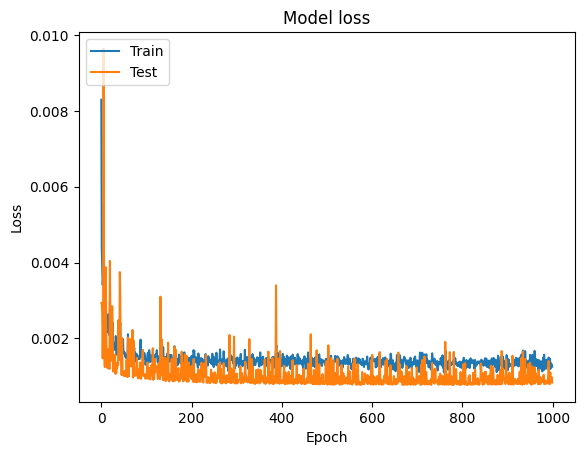

In [ ]:
plt.plot(historylstm3.history['loss'])
plt.plot(historylstm3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

12/12 [==============================] - 0s 2ms/step


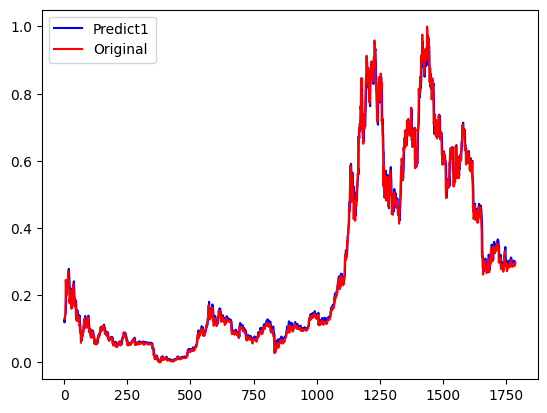

In [ ]:
lstm3train  = lstm3.predict(x_train)
lstm3val = lstm3.predict(x_vaild)
lstm3pre = lstm3.predict(x_test)
pre = lstm3.predict(x_train)
pre1=lstm3.predict(x_vaild)
fc=np.concatenate((pre,pre1))
yreal=np.concatenate((y_train,y_vaild))
plt.figure(facecolor='white')
pd.Series(fc.reshape(-1)).plot(color='blue', label='Predict1')
pd.Series(yreal.reshape(-1)).plot(color='red', label='Original')
plt.legend()
plt.show()

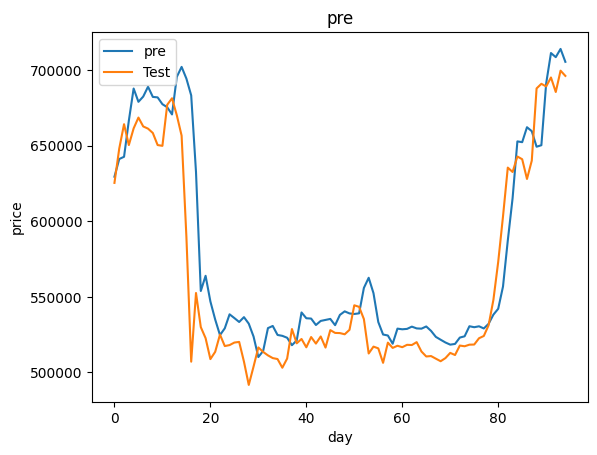

30348.17940011246

In [ ]:
lstm3pre= scaler.inverse_transform(lstm3pre)#將資料轉換回來
y_test = scaler.inverse_transform(y_test.reshape(-1,1))
plt.figure()
plt.plot(lstm3pre)
plt.plot(y_test)
plt.title('pre')
plt.ylabel('price')
plt.xlabel('day')
plt.legend(['pre', 'Test'], loc='upper left')
plt.show()
root_mean_squared_error(lstm3pre,y_test)

In [ ]:
## 兩層 LSTM
def lstm_model4(input_length, input_dim):

    d=0.3
    model4= Sequential()
    model4.add(LSTM(64,input_shape=(input_length, input_dim),return_sequences=True))
    model4.add(Dropout(d))

    model4.add(LSTM(32,input_shape=(input_length, input_dim),return_sequences=False))
    model4.add(Dropout(d))
    
    model4.add(Dense(1,activation='linear'))#linear / softmax(多分類) / sigmoid(二分法)

    # optimizer = tf.keras.optimizers.Adam(lr=0.00005)
    model4.compile(loss='mse',optimizer='adam')#loss=mse/categorical_crossentropy
    return model4 

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=300, monitor = 'val_loss')
    ]
filepath="lstm.best.hdf6"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min',save_best_only=True)

call_backlist = [ my_callbacks,checkpoint]
callbacks=call_backlist
lstm4 = lstm_model4(10,5)
historylstm4 = lstm4.fit( x_train, y_train, batch_size=30,shuffle=False , epochs=1000,validation_data=(x_vaild,y_vaild),callbacks=call_backlist)
lstm4.summary()

Epoch 1/1000
48/48 [==============================] - ETA: 0s - loss: 0.0101
Epoch 1: val_loss improved from inf to 0.00554, saving model to lstm.best.hdf6


48/48 [==============================] - 13s 195ms/step - loss: 0.0101 - val_loss: 0.0055
Epoch 2/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0044
Epoch 2: val_loss improved from 0.00554 to 0.00217, saving model to lstm.best.hdf6


48/48 [==============================] - 8s 169ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 3/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0033    
Epoch 3: val_loss improved from 0.00217 to 0.00204, saving model to lstm.best.hdf6


48/48 [==============================] - 9s 181ms/step - loss: 0.0056 - val_loss: 0.0020
Epoch 4/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0065
Epoch 4: val_loss did not improve from 0.00204
48/48 [==============================] - 1s 17ms/step - loss: 0.0106 - val_loss: 0.0139
Epoch 5/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0081
Epoch 5: val_loss did not improve from 0.00204
48/48 [==============================] - 1s 18ms/step - loss: 0.0087 - val_loss: 0.0076
Epoch 6/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0071
Epoch 6: val_loss did not improve from 0.00204
48/48 [==============================] - 1s 14ms/step - loss: 0.0082 - val_loss: 0.0140
Epoch 7/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0039
Epoch 7: val_loss did not improve from 0.00204
48/48 [==============================] - 1s 14ms/step - loss: 0.0044 - val_loss: 0.0027
Epoch 8/1000
45/48 [===========================>..] - ETA: 0s -

48/48 [==============================] - 8s 177ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 9/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0031
Epoch 9: val_loss did not improve from 0.00204
48/48 [==============================] - 1s 16ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 10/1000
48/48 [==============================] - ETA: 0s - loss: 0.0037
Epoch 10: val_loss did not improve from 0.00204
48/48 [==============================] - 1s 17ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 11/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0022
Epoch 11: val_loss improved from 0.00204 to 0.00192, saving model to lstm.best.hdf6


48/48 [==============================] - 8s 169ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 12/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0025    
Epoch 12: val_loss did not improve from 0.00192
48/48 [==============================] - 1s 15ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 13/1000
48/48 [==============================] - ETA: 0s - loss: 0.0034
Epoch 13: val_loss did not improve from 0.00192
48/48 [==============================] - 1s 21ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 14/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0032
Epoch 14: val_loss did not improve from 0.00192
48/48 [==============================] - 1s 23ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 15/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0033
Epoch 15: val_loss did not improve from 0.00192
48/48 [==============================] - 1s 17ms/step - loss: 0.0034 - val_loss: 0.0049
Epoch 16/1000
46/48 [===========================>..

48/48 [==============================] - 9s 187ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 17/1000
48/48 [==============================] - ETA: 0s - loss: 0.0031
Epoch 17: val_loss improved from 0.00188 to 0.00150, saving model to lstm.best.hdf6


48/48 [==============================] - 9s 185ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 18/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0025
Epoch 18: val_loss did not improve from 0.00150
48/48 [==============================] - 1s 13ms/step - loss: 0.0042 - val_loss: 0.0053
Epoch 19/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0044
Epoch 19: val_loss did not improve from 0.00150
48/48 [==============================] - 1s 13ms/step - loss: 0.0063 - val_loss: 0.0122
Epoch 20/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0024
Epoch 20: val_loss did not improve from 0.00150
48/48 [==============================] - 1s 13ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 21/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0025
Epoch 21: val_loss did not improve from 0.00150
48/48 [==============================] - 1s 13ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 22/1000
47/48 [============================>.] - 

48/48 [==============================] - 9s 184ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 37/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0017
Epoch 37: val_loss did not improve from 0.00147
48/48 [==============================] - 1s 14ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 38/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0016    
Epoch 38: val_loss did not improve from 0.00147
48/48 [==============================] - 1s 13ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 39/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0028
Epoch 39: val_loss did not improve from 0.00147
48/48 [==============================] - 1s 12ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 40/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0030
Epoch 40: val_loss did not improve from 0.00147
48/48 [==============================] - 1s 13ms/step - loss: 0.0034 - val_loss: 0.0059
Epoch 41/1000
48/48 [==============================

48/48 [==============================] - 7s 156ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 53/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0018
Epoch 53: val_loss did not improve from 0.00142
48/48 [==============================] - 1s 12ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 54/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0019    
Epoch 54: val_loss did not improve from 0.00142
48/48 [==============================] - 1s 13ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 55/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0017    
Epoch 55: val_loss did not improve from 0.00142
48/48 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 56/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0019
Epoch 56: val_loss did not improve from 0.00142
48/48 [==============================] - 1s 15ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 57/1000
46/48 [==========================

48/48 [==============================] - 9s 185ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 59/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0016
Epoch 59: val_loss improved from 0.00140 to 0.00124, saving model to lstm.best.hdf6


48/48 [==============================] - 9s 191ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 60/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0017    
Epoch 60: val_loss did not improve from 0.00124
48/48 [==============================] - 1s 13ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 61/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0018    
Epoch 61: val_loss did not improve from 0.00124
48/48 [==============================] - 1s 13ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 62/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0016
Epoch 62: val_loss did not improve from 0.00124
48/48 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 63/1000
43/48 [=========================>....] - ETA: 0s - loss: 0.0017    
Epoch 63: val_loss did not improve from 0.00124
48/48 [==============================] - 1s 12ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 64/1000
46/48 [======================

48/48 [==============================] - 9s 186ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 67/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0014    
Epoch 67: val_loss did not improve from 0.00115
48/48 [==============================] - 1s 14ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 68/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0019
Epoch 68: val_loss did not improve from 0.00115
48/48 [==============================] - 1s 14ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 69/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 69: val_loss did not improve from 0.00115
48/48 [==============================] - 1s 14ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 70/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0021
Epoch 70: val_loss did not improve from 0.00115
48/48 [==============================] - 1s 13ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 71/1000
44/48 [==========================>...

48/48 [==============================] - 8s 160ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 78/1000
48/48 [==============================] - ETA: 0s - loss: 0.0020
Epoch 78: val_loss improved from 0.00114 to 0.00114, saving model to lstm.best.hdf6


48/48 [==============================] - 9s 189ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 79/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0017    
Epoch 79: val_loss improved from 0.00114 to 0.00107, saving model to lstm.best.hdf6


48/48 [==============================] - 9s 185ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 80/1000
48/48 [==============================] - ETA: 0s - loss: 0.0017
Epoch 80: val_loss did not improve from 0.00107
48/48 [==============================] - 1s 14ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 81/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 81: val_loss did not improve from 0.00107
48/48 [==============================] - 1s 12ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 82/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 82: val_loss did not improve from 0.00107
48/48 [==============================] - 1s 14ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 83/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0013    
Epoch 83: val_loss did not improve from 0.00107
48/48 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 84/1000
48/48 [==============================

48/48 [==============================] - 7s 157ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 98/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0016
Epoch 98: val_loss did not improve from 0.00104
48/48 [==============================] - 1s 16ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 99/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0016
Epoch 99: val_loss did not improve from 0.00104
48/48 [==============================] - 1s 17ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 100/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0013    
Epoch 100: val_loss improved from 0.00104 to 0.00103, saving model to lstm.best.hdf6


48/48 [==============================] - 9s 182ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 101/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 101: val_loss did not improve from 0.00103
48/48 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 102/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0026
Epoch 102: val_loss did not improve from 0.00103
48/48 [==============================] - 1s 12ms/step - loss: 0.0027 - val_loss: 0.0052
Epoch 103/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0020
Epoch 103: val_loss did not improve from 0.00103
48/48 [==============================] - 1s 13ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 104/1000
48/48 [==============================] - ETA: 0s - loss: 0.0020
Epoch 104: val_loss did not improve from 0.00103
48/48 [==============================] - 1s 17ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 105/1000
47/48 [=========================

48/48 [==============================] - 9s 186ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 114/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0015    
Epoch 114: val_loss did not improve from 0.00102
48/48 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 115/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0017
Epoch 115: val_loss did not improve from 0.00102
48/48 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 116/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0014    
Epoch 116: val_loss did not improve from 0.00102
48/48 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 117/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 117: val_loss improved from 0.00102 to 0.00100, saving model to lstm.best.hdf6


48/48 [==============================] - 9s 187ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 118/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0013    
Epoch 118: val_loss did not improve from 0.00100
48/48 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 119/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0015    
Epoch 119: val_loss did not improve from 0.00100
48/48 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 120/1000
48/48 [==============================] - ETA: 0s - loss: 0.0026
Epoch 120: val_loss did not improve from 0.00100
48/48 [==============================] - 1s 13ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 121/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0019
Epoch 121: val_loss did not improve from 0.00100
48/48 [==============================] - 1s 13ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 122/1000
48/48 [=================

48/48 [==============================] - 8s 160ms/step - loss: 0.0016 - val_loss: 9.4948e-04
Epoch 136/1000
48/48 [==============================] - ETA: 0s - loss: 0.0017
Epoch 136: val_loss did not improve from 0.00095
48/48 [==============================] - 1s 14ms/step - loss: 0.0017 - val_loss: 9.5290e-04
Epoch 137/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 137: val_loss did not improve from 0.00095
48/48 [==============================] - 1s 12ms/step - loss: 0.0017 - val_loss: 9.9053e-04
Epoch 138/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0017
Epoch 138: val_loss did not improve from 0.00095
48/48 [==============================] - 1s 14ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 139/1000
48/48 [==============================] - ETA: 0s - loss: 0.0020
Epoch 139: val_loss did not improve from 0.00095
48/48 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 140/1000
46/48 [=============

48/48 [==============================] - 9s 196ms/step - loss: 0.0017 - val_loss: 9.4675e-04
Epoch 149/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0013    
Epoch 149: val_loss did not improve from 0.00095
48/48 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 150/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0013    
Epoch 150: val_loss did not improve from 0.00095
48/48 [==============================] - 1s 13ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 151/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0013
Epoch 151: val_loss did not improve from 0.00095
48/48 [==============================] - 1s 13ms/step - loss: 0.0016 - val_loss: 9.5437e-04
Epoch 152/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 152: val_loss did not improve from 0.00095
48/48 [==============================] - 1s 14ms/step - loss: 0.0015 - val_loss: 9.6614e-04
Epoch 153/1000
47/48 [=====

48/48 [==============================] - 8s 180ms/step - loss: 0.0018 - val_loss: 9.4115e-04
Epoch 181/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 181: val_loss did not improve from 0.00094
48/48 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 182/1000
48/48 [==============================] - ETA: 0s - loss: 0.0017
Epoch 182: val_loss did not improve from 0.00094
48/48 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 183/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 183: val_loss did not improve from 0.00094
48/48 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 184/1000
48/48 [==============================] - ETA: 0s - loss: 0.0023
Epoch 184: val_loss did not improve from 0.00094
48/48 [==============================] - 1s 15ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 185/1000
45/48 [=====================

48/48 [==============================] - 9s 189ms/step - loss: 0.0016 - val_loss: 8.7754e-04
Epoch 194/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 194: val_loss did not improve from 0.00088
48/48 [==============================] - 1s 16ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 195/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 195: val_loss did not improve from 0.00088
48/48 [==============================] - 1s 14ms/step - loss: 0.0015 - val_loss: 9.3784e-04
Epoch 196/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0014    
Epoch 196: val_loss did not improve from 0.00088
48/48 [==============================] - 1s 15ms/step - loss: 0.0017 - val_loss: 9.8321e-04
Epoch 197/1000
48/48 [==============================] - ETA: 0s - loss: 0.0017
Epoch 197: val_loss did not improve from 0.00088
48/48 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 198/1000
46/48 [=========

48/48 [==============================] - 8s 175ms/step - loss: 0.0015 - val_loss: 8.4957e-04
Epoch 253/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0014
Epoch 253: val_loss did not improve from 0.00085
48/48 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 254/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 254: val_loss did not improve from 0.00085
48/48 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 255/1000
44/48 [==========================>...] - ETA: 0s - loss: 0.0012    
Epoch 255: val_loss did not improve from 0.00085
48/48 [==============================] - 1s 14ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 256/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 256: val_loss did not improve from 0.00085
48/48 [==============================] - 1s 14ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 257/1000
48/48 [=================

48/48 [==============================] - 9s 191ms/step - loss: 0.0017 - val_loss: 8.4180e-04
Epoch 285/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0018
Epoch 285: val_loss did not improve from 0.00084
48/48 [==============================] - 1s 13ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 286/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0017
Epoch 286: val_loss did not improve from 0.00084
48/48 [==============================] - 1s 14ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 287/1000
48/48 [==============================] - ETA: 0s - loss: 0.0022
Epoch 287: val_loss did not improve from 0.00084
48/48 [==============================] - 1s 14ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 288/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 288: val_loss did not improve from 0.00084
48/48 [==============================] - 1s 15ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 289/1000
48/48 [=====================

48/48 [==============================] - 9s 185ms/step - loss: 0.0016 - val_loss: 8.3795e-04
Epoch 305/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0016    
Epoch 305: val_loss did not improve from 0.00084
48/48 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 306/1000
48/48 [==============================] - ETA: 0s - loss: 0.0015
Epoch 306: val_loss did not improve from 0.00084
48/48 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 8.8939e-04
Epoch 307/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0016    
Epoch 307: val_loss did not improve from 0.00084
48/48 [==============================] - 1s 13ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 308/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0020
Epoch 308: val_loss did not improve from 0.00084
48/48 [==============================] - 1s 13ms/step - loss: 0.0027 - val_loss: 0.0039
Epoch 309/1000
46/48 [=========

48/48 [==============================] - 8s 169ms/step - loss: 0.0016 - val_loss: 8.2023e-04
Epoch 332/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 332: val_loss did not improve from 0.00082
48/48 [==============================] - 1s 14ms/step - loss: 0.0018 - val_loss: 8.9485e-04
Epoch 333/1000
45/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 333: val_loss did not improve from 0.00082
48/48 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 334/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0012    
Epoch 334: val_loss did not improve from 0.00082
48/48 [==============================] - 1s 13ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 335/1000
48/48 [==============================] - ETA: 0s - loss: 0.0017
Epoch 335: val_loss did not improve from 0.00082
48/48 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 8.6289e-04
Epoch 336/1000
46/48 [=====

48/48 [==============================] - 9s 199ms/step - loss: 0.0015 - val_loss: 8.1987e-04
Epoch 485/1000
48/48 [==============================] - ETA: 0s - loss: 0.0017
Epoch 485: val_loss did not improve from 0.00082
48/48 [==============================] - 1s 14ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 486/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 486: val_loss did not improve from 0.00082
48/48 [==============================] - 1s 14ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 487/1000
48/48 [==============================] - ETA: 0s - loss: 0.0016
Epoch 487: val_loss did not improve from 0.00082
48/48 [==============================] - 1s 14ms/step - loss: 0.0016 - val_loss: 9.4447e-04
Epoch 488/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0013    
Epoch 488: val_loss did not improve from 0.00082
48/48 [==============================] - 1s 14ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 489/1000
48/48 [=============

48/48 [==============================] - 9s 190ms/step - loss: 0.0016 - val_loss: 8.1630e-04
Epoch 543/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0016
Epoch 543: val_loss did not improve from 0.00082
48/48 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 544/1000
46/48 [===========================>..] - ETA: 0s - loss: 0.0013
Epoch 544: val_loss did not improve from 0.00082
48/48 [==============================] - 1s 14ms/step - loss: 0.0015 - val_loss: 9.5642e-04
Epoch 545/1000
47/48 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 545: val_loss did not improve from 0.00082
48/48 [==============================] - 1s 14ms/step - loss: 0.0015 - val_loss: 8.5395e-04
Epoch 546/1000
48/48 [==============================] - ETA: 0s - loss: 0.0014
Epoch 546: val_loss did not improve from 0.00082
48/48 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 8.8338e-04
Epoch 547/1000
47/48 [=========

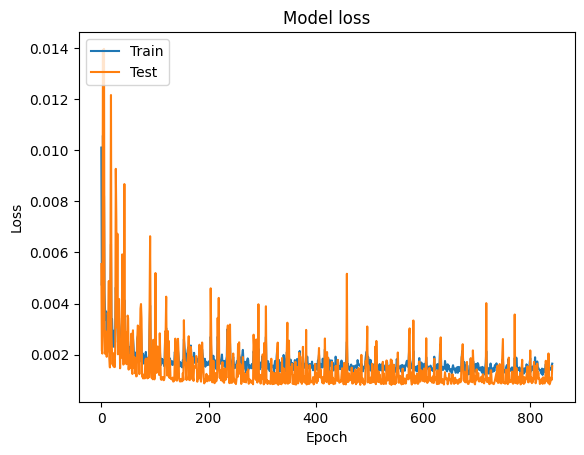

In [ ]:
plt.plot(historylstm4.history['loss'])
plt.plot(historylstm4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

12/12 [==============================] - 0s 3ms/step


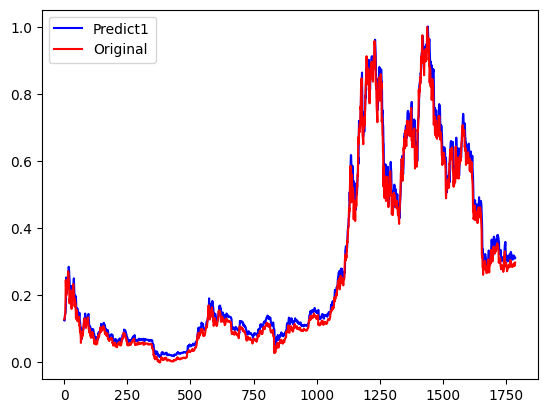

In [ ]:
lstm4train  = lstm4.predict(x_train)
lstm4val = lstm4.predict(x_vaild)
lstm4pre = lstm4.predict(x_test)
pre = lstm4.predict(x_train)
pre1=lstm4.predict(x_vaild)
fc=np.concatenate((pre,pre1))
yreal=np.concatenate((y_train,y_vaild))
plt.figure(facecolor='white')
pd.Series(fc.reshape(-1)).plot(color='blue', label='Predict1')
pd.Series(yreal.reshape(-1)).plot(color='red', label='Original')
plt.legend()
plt.show()

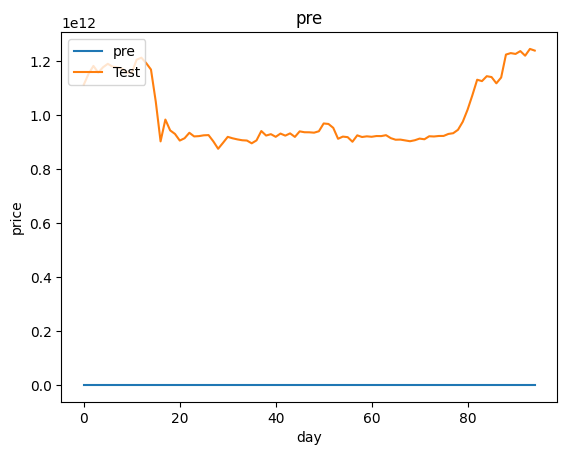

1009468184476.8667

In [ ]:
lstm4pre= scaler.inverse_transform(lstm4pre)#將資料轉換回來
y_test = scaler.inverse_transform(y_test.reshape(-1,1))
plt.figure()
plt.plot(lstm4pre)
plt.plot(y_test)
plt.title('pre')
plt.ylabel('price')
plt.xlabel('day')
plt.legend(['pre', 'Test'], loc='upper left')
plt.show()
root_mean_squared_error(lstm4pre,y_test)